In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import numpy as np
import itertools
from tabulate import tabulate

from action_utils import *

In [3]:
main_df = pd.read_csv("datasets/my_uspto/supervised_zinc_gin/dataset.csv", index_col=0)

In [4]:
N = 50000

# take N samples of it
np.random.seed(42)
print(main_df.shape)
elements_to_fetch = np.random.randint(0, main_df.shape[0], size=(N,))
main_df = main_df.iloc[elements_to_fetch]
print(main_df.shape)

(3976954, 10)
(50000, 10)


# Neural Network!

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 23282.0371
Epoch 2, Loss: 13480.6406
Epoch 3, Loss: 4864.4717
Epoch 4, Loss: 1271.2633
Epoch 5, Loss: 409.2057
Epoch 6, Loss: 262.6316
Epoch 7, Loss: 227.0993
Epoch 8, Loss: 237.1659
Epoch 9, Loss: 240.6803
Epoch 10, Loss: 250.4783

FINAL TEST LOSS: 78.60089874267578


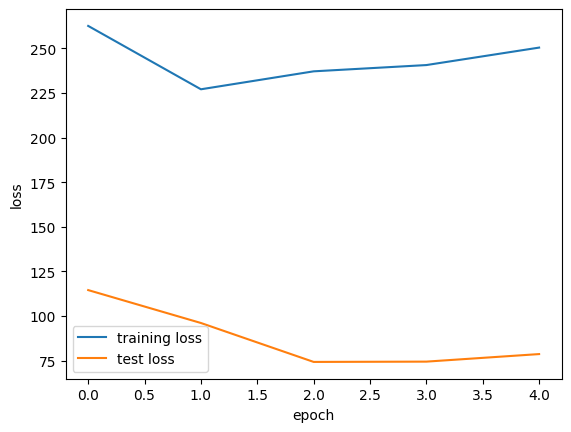

CPU times: user 5.6 s, sys: 214 ms, total: 5.81 s
Wall time: 2.36 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [81]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out
    

def train(X, Y, num_hidden=1, hidden_size=50, lr=1e-2, bs=64, epochs=100):
    train_X = torch.Tensor(X[:int(X.shape[0]*0.7)]).to(device)
    train_Y = torch.Tensor(Y[:int(Y.shape[0]*0.7)]).to(device)

    test_X = torch.Tensor(X[int(X.shape[0]*0.7):]).to(device)
    test_Y = torch.Tensor(Y[int(Y.shape[0]*0.7):]).to(device)
    
    model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

    loss_list = []
    test_loss = []

    # Train the model
    for epoch in range(epochs):
        for i in range(0, train_X.shape[0], batch_size):
            model.train()
            # Forward pass
            outputs = model(train_X[i:i+batch_size])
            loss = criterion(outputs, train_Y[i:i+batch_size])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_list.append(loss.item())
        print ('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        
        model.eval()
        test_loss.append(criterion(model(test_X), test_Y).item()) 
    print("\nFINAL TEST LOSS:", test_loss[-1])
        
    plt.plot(loss_list[5:], label="training loss")
    plt.plot(test_loss[5:], label="test loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
        
    return model
        
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

# Embedding type 2 - GIN training using attribute masking on clintox

In [8]:
from torchdrug import data

In [13]:
model_name = "models/zinc2m_gin.pth"
clintox_gin = torch.load(model_name).to(device)

In [75]:
def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def clintox_gin_mol_embedding(smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    else:
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    mol = mol.to(device)
    emb = clintox_gin(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach().cpu().numpy()

def clintox_gin_atom_embedding(smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = clintox_gin(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = clintox_gin(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach().cpu()

def clinton_gin_action_embedding(action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
#     print(clintox_gin_mol_embedding(rsub).shape)
#     print(clintox_gin_atom_embedding(rsig, rcen).shape)
#     print(clintox_gin_mol_embedding(rsig).shape)
#     print(clintox_gin_mol_embedding(psub).shape)
#     print(clintox_gin_atom_embedding(psig, pcen).shape)
#     print(clintox_gin_mol_embedding(psig).shape)
    embedding = np.concatenate([
#                         clintox_gin_mol_embedding(rsub), 
#                         clintox_gin_atom_embedding(rsig, rcen) / 5, 
                        clintox_gin_mol_embedding(rsig), 
#                         clintox_gin_mol_embedding(psub), 
#                         clintox_gin_atom_embedding(psig, pcen) / 5, 
                        clintox_gin_mol_embedding(psig)
                    ], axis=1)
    return embedding

In [67]:
batch_size = 64
X = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(np.concatenate([clintox_gin_mol_embedding(reactants), clintox_gin_mol_embedding(products)], axis=1))
X = np.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

100%|██████████████████████████████████████████████████████████████| 782/782 [03:05<00:00,  4.21it/s]


(50000, 256)

In [77]:
batch_size = 64
Y = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    Y.append(clinton_gin_action_embedding(main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = np.concatenate(Y)
Y.shape

  7%|████▌                                                          | 57/782 [00:12<02:44,  4.41it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
 50%|██████████████████████████████▊                               | 388/782 [01:18<01:07,  5.88it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
100%|██████████████████████████████████████████████████████████████| 782/782 [02:36<00:00,  5.00it/s]


(50000, 256)

### MSE training

Epoch 1, Loss: 0.0444
Epoch 2, Loss: 0.0341
Epoch 3, Loss: 0.0297
Epoch 4, Loss: 0.0246
Epoch 5, Loss: 0.0240
Epoch 6, Loss: 0.0196
Epoch 7, Loss: 0.0174
Epoch 8, Loss: 0.0161
Epoch 9, Loss: 0.0150
Epoch 10, Loss: 0.0142
Epoch 11, Loss: 0.0131
Epoch 12, Loss: 0.0157
Epoch 13, Loss: 0.0130
Epoch 14, Loss: 0.0121
Epoch 15, Loss: 0.0114
Epoch 16, Loss: 0.0098
Epoch 17, Loss: 0.0102
Epoch 18, Loss: 0.0092
Epoch 19, Loss: 0.0093
Epoch 20, Loss: 0.0084
Epoch 21, Loss: 0.0082
Epoch 22, Loss: 0.0079
Epoch 23, Loss: 0.0086
Epoch 24, Loss: 0.0081
Epoch 25, Loss: 0.0075
Epoch 26, Loss: 0.0079
Epoch 27, Loss: 0.0078
Epoch 28, Loss: 0.0070
Epoch 29, Loss: 0.0072
Epoch 30, Loss: 0.0066
Epoch 31, Loss: 0.0069
Epoch 32, Loss: 0.0067
Epoch 33, Loss: 0.0068
Epoch 34, Loss: 0.0069
Epoch 35, Loss: 0.0061
Epoch 36, Loss: 0.0058
Epoch 37, Loss: 0.0057
Epoch 38, Loss: 0.0059
Epoch 39, Loss: 0.0059
Epoch 40, Loss: 0.0058
Epoch 41, Loss: 0.0056
Epoch 42, Loss: 0.0053
Epoch 43, Loss: 0.0054
Epoch 44, Loss: 0.00

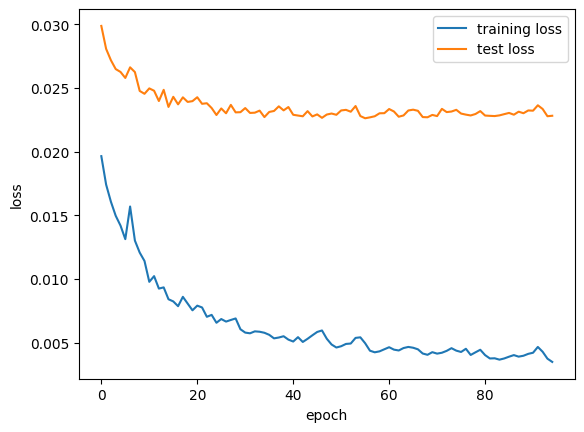

In [109]:
model = train(X, Y, hidden_size=500, num_hidden=3, lr=1e-3, epochs=100)

In [110]:
torch.save(model, "datasets/my_uspto/supervised_zinc_gin/mse_model.pth")

In [82]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)

action_dataset = action_dataset.loc[action_dataset["reactant_works"] & action_dataset["reactant_tested"] & action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset.shape

action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]

print(action_dataset.shape)

action_embeddings = []
for i in tqdm.tqdm(range(0, action_dataset.shape[0], batch_size)):
    action_embeddings.append(clinton_gin_action_embedding(action_dataset.iloc[i:i+batch_size]))
action_embeddings = np.concatenate(action_embeddings)
print(action_embeddings.shape)

(88995, 8)


  7%|████▏                                                         | 93/1391 [00:19<04:11,  5.16it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
 47%|████████████████████████████▋                                | 654/1391 [02:16<02:24,  5.12it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
 61%|█████████████████████████████████████                        | 845/1391 [02:59<01:54,  4.76it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:

(88995, 256)


### Back to modeling

In [85]:
correct_indices = []
action_embedding_indices = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    row = main_df.iloc[i]
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    
    indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
    action_embedding_indices.append(indices_used_for_data)

    applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
    correct_indices.append((applicable_actions_df.index == row.name).argmax())
    
    assert correct_indices[-1] < len(action_embedding_indices[-1]), f"WHAT!? {correct_indices[-1]} vs {len(indices_used_for_data)}"

100%|██████████████████████████████████████████████████████████| 50000/50000 [27:13<00:00, 30.61it/s]


In [112]:
def get_ranking(pred, emb_for_comparison, correct_index, distance="euclidean", k=None):
    '''
    Get the rank of the prediction from the applicable actions.
    Returns (rank, [list_of_indices before <rank>])
    '''
    if distance == "euclidean":
        dist = ((emb_for_comparison-pred)**2).sum(axis=1)
    elif distance == "cosine":
        dist = 1 - (emb_for_comparison.dot(pred))/(np.linalg.norm(emb_for_comparison, axis=1)*np.linalg.norm(pred))

    maxy = max(dist)

    list_of_indices = []
    for attempt in range(dist.shape[0]):
        miny = dist.argmin()
#         print(miny, correct_index, dist[correct_index], min(dist), maxy)
        if dist[miny] == dist[correct_index]:
#             print(i, attempt)
            break
        else:
            list_of_indices.append(miny)
            if k is not None and len(list_of_indices) == k:
                return list_of_indices
            dist[miny] = 100000
    
    # When the rank(correct_index) < k, then returns <rank, list>. So this extra condition - add some indices after rank(correct_index) to the list
    if k is not None:
        dist[miny] = 100000
        for attempt in range(min(k, emb_for_comparison.shape[0]-1) - len(list_of_indices)):
            miny = dist.argmin()
            list_of_indices.append(miny)
            dist[miny] = 100000
        return list_of_indices
    return attempt, list_of_indices

def get_top_k_indices(pred, emb_for_comparison, correct_index, distance="euclidean", k=1):
    return get_ranking(pred, emb_for_comparison, correct_index, distance, k)
    
pred = model(torch.Tensor(X[40000:]).to(device)).detach().cpu().numpy()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[40000+i]], correct_indices[40000+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
    l.append(rank)
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|█████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 773.19it/s]

57.0903(1699.503) +- 190.12729616209768  


In [99]:
train_idx = np.arange(0, int(X.shape[0]*0.8))
test_idx = np.arange(int(X.shape[0]*0.8), X.shape[0])

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
9997.575195(1)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤════════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)      

9996.503906(12)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 16.4308 │ 0.759476 │ 48.9174(1699.503) +- 134.2163 │ 60.0776(1699.503) +- 143.7015 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

9996.492188(13)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤═══════

╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 10.6521 │ 0.806958 │ 40.2264(1699.503) +- 129.5021 │ 47.0741(1699.503) +- 125.0417 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

9996.372070(24)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════

9996.247070(35)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 8.40483 │ 0.828194 │ 41.1622(1699.503) +- 134.8507 │ 44.7417(1699.503) +- 124.7349 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

9996.246094(36)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤═══════

╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 7.25365 │ 0.839201 │ 41.3596(1699.503) +- 138.5416 │ 42.9208(1699.503) +- 121.3519 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

9996.219727(47)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════

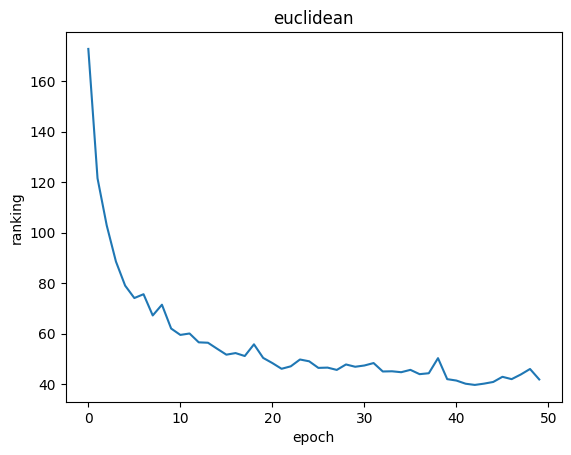

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
9999.509766(1)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                 │
╞══════

9999.497070(12)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                 │
╞═══════╪═════════╪══════════╪════════════════════════════════╪══════════════════════════════╡
│ 0:256 │ 10.1918 │ 0.435207 │ 202.3996(1699.503) +- 366.7945 │ 45.3048(1699.503) +- 97.9678 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧══════════════════════════════╛

9999.496094(13)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤════════╤══════════╤════════════════════════════════╤

9999.499023(24)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 10.7673 │ 0.427329 │ 195.6725(1699.503) +- 361.6637 │ 46.8404(1699.503) +- 100.3505 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

9999.499023(25)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════

9999.496094(36)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 11.2569 │ 0.424686 │ 177.5031(1699.503) +- 342.5197 │ 47.0200(1699.503) +- 100.1064 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

9999.496094(37)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════

9999.495117(48)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                 │
╞═══════╪═════════╪══════════╪════════════════════════════════╪══════════════════════════════╡
│ 0:256 │ 11.7151 │  0.42577 │ 162.9664(1699.503) +- 325.7825 │ 46.1018(1699.503) +- 97.3106 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧══════════════════════════════╛

9999.495117(49)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤════════╤══════════╤════════════════════════════════╤

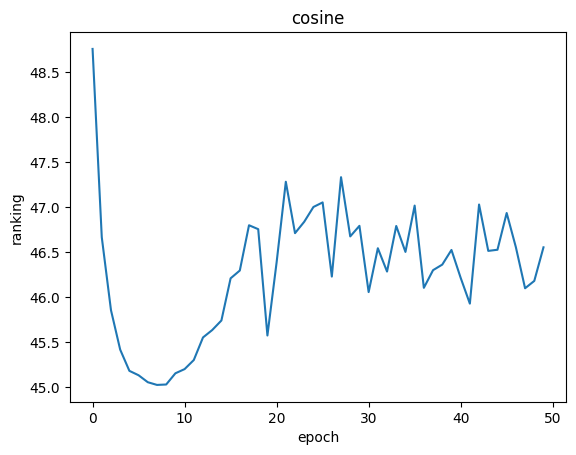

CPU times: user 1d 2h 38min 10s, sys: 1h 26min 52s, total: 1d 4h 5min 2s
Wall time: 2h 23min 38s


In [100]:
%%time
%matplotlib inline
train_X = torch.Tensor(X[train_idx]).to(device)
train_Y = torch.Tensor(Y[train_idx]).to(device)

test_X = torch.Tensor(X[test_idx]).to(device)
test_Y = torch.Tensor(Y[test_idx]).to(device)

hidden_size, num_hidden, lr, epochs, batch_size = 512, 3, 1e-3, 50, 128
model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

for margin, distance_metric in itertools.product([10000], ["euclidean", "cosine"]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    if distance_metric == "euclidean":
        criterion = nn.TripletMarginLoss(margin=margin)
    elif distance_metric == "cosine":
        criterion = nn.TripletMarginWithDistanceLoss(margin=margin, distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x, y))

    loss_list = []
    test_loss = []
    ultra_rank_list = []

    # Train the model
    for epoch in range(epochs):
        model.train()
        for i in range(0, train_X.shape[0], batch_size):
            # Forward pass
            outputs = model(train_X[i:i+batch_size])

            # Calc negatives
            positive_index = []
            negatives = []
            for _i in range(outputs.shape[0]):
                act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_indices[train_idx[i+_i]]
                top = get_top_k_indices(outputs[_i].detach().cpu().numpy(), act_emb_for_i, correct_index, distance=distance_metric, k=50)

                positive_index.extend([_i]*len(top))
                negatives.append(act_emb_for_i[top])
            negatives = np.concatenate(negatives, axis=0)
            
            # Calc loss
            loss = criterion(outputs[positive_index], train_Y[i:i+batch_size][positive_index], torch.Tensor(negatives).to(device))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list.append(loss.item())
        print ('{:.6f}({})'.format(loss.item(), epoch+1), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# Margin = {margin} | distance_metric = {distance_metric} | topk distance = {distance_metric} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_X).detach().cpu().numpy() 
            true = test_Y.detach().cpu().numpy()

            metric_df = pd.DataFrame(columns=["rMSE", "Cosine", "Rank(euclid)", "Rank(cosine)"])

            # Print Test metrics
            mse_list = []
            cosine_list = []
            idx_list = []
            mse_list.append( (((pred-true)**2).sum(axis=1)**0.5).mean() )
            cosine_list.append(((pred*true).sum(axis=1) / np.linalg.norm(pred, axis=1) / np.linalg.norm(true, axis=1)).mean())    
            idx_list.append(f"0:{Y.shape[1]}")

            # Print Test metric - Rank
            d = {}
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
                    l.append(rank)
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                d[dist] = rank_list

            metric_df["rMSE"] = mse_list
            metric_df["Cosine"] = cosine_list
            metric_df["Rank(euclid)"] = d["euclidean"]
            metric_df["Rank(cosine)"] = d["cosine"]
            ultra_rank_list.append(np.mean(l))
            metric_df.index = idx_list
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
    plt.plot(ultra_rank_list)
    plt.title(distance_metric)
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.show()

(array([2370.,  557.,  422.,  341.,  310.,  251.,  223.,  224.,  201.,
         192.,  166.,  163.,  310.,  130.,  142.,  147.,  155.,  136.,
         121.,  126.,  117.,  104.,   92.,   81.,   77.,  150.,   58.,
          63.,   55.,   58.,   57.,   46.,   55.,   46.,   46.,   46.,
          39.,   71.,   42.,   34.,   28.,   24.,   23.,   28.,   21.,
          32.,   24.,   29.,   33.,   18.,   52.,   19.,   19.,   18.,
          24.,   17.,   14.,   19.,   25.,   20.,   20.,   23.,   31.,
          20.,   17.,   17.,   16.,   13.,   11.,   15.,    6.,   16.,
          17.,   19.,   12.,   20.,    6.,    8.,    9.,    9.,   12.,
           9.,    4.,   12.,    6.,   11.,    9.,   16.,   14.,    8.,
           8.,    5.,    9.,    9.,    4.,   11.,    8.,    7.,    6.,
          16.]),
 array([  0.  ,   1.08,   2.16,   3.24,   4.32,   5.4 ,   6.48,   7.56,
          8.64,   9.72,  10.8 ,  11.88,  12.96,  14.04,  15.12,  16.2 ,
         17.28,  18.36,  19.44,  20.52,  21.6 ,  22.68,  2

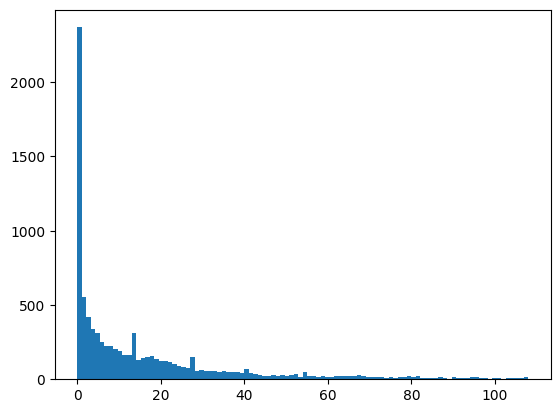

In [123]:
arr = np.sort(l)

plt.hist(arr[:int(arr.shape[0]*0.9)], bins=100)

In [2]:
(arr <= 10).sum() / arr.shape[0] * 100

50.97